In [18]:
import numpy as np
import pandas as pd
import warnings

#suppress warnings
warnings.filterwarnings('ignore')

In [19]:
np.random.seed(42)

In [20]:
import matplotlib.pyplot as plot

In [28]:
from sklearn.metrics import classification_report
from sklearn.model_selection import ShuffleSplit, train_test_split
from sklearn.preprocessing import StandardScaler

# Implemetação

Definição de códigos.

## Rede Neural

MLP com uma camada escondida, utilzando gradiente conjugado para aproximação da hessiana e taxa de aprendizado dinâmica com bisseção.

In [59]:
def train(X_train, y_train, X_valid, y_valid, hidden_layers, ns, dataset='k-fold'):
  N, ne = X_train.shape
  N_valid, _ = X_valid.shape

  # weights
  A = np.random.rand(hidden_layers, ne + 1)/5
  B = np.random.rand(ns, hidden_layers + 1)/5

  X_train = np.hstack([X_train, np.ones((N, 1))])
  X_valid = np.hstack([X_valid, np.ones((N_valid, 1))])

  errors_train = []
  errors_valid = []
  errors_min = []

  # output
  y = calculate_output(X_train, A, B, N)
  error = y - y_train
  square_error_train = 1/N * sum(error * error)
  errors_train.append(square_error_train)
  
  y = calculate_output(X_valid, A, B, N_valid)
  error = y - y_valid
  square_error_valid = 1/N_valid * sum(error * error)
  errors_valid.append(square_error_valid)
  
  min_error = square_error_valid
  best_A = A
  best_B = B

  epoch = 0
  max_epoch = 5000
    
  f = open(f"MLP/{dataset}/error.txt","a+")
  f.write(f"epoch: {epoch}, train: {square_error_train}, valid: {square_error_valid}\n")
  while square_error_train > 1e-3 and epoch < max_epoch:
    epoch = epoch + 1

    dJdA_current, dJdB_current = calculate_gradient(X_train, y_train, A, B, N)

    if epoch == 1:
      dJdA = dJdA_current
      dJdB = dJdB_current
      dJdA_old = dJdA_current
      dJdB_old = dJdB_current
    else:
      dJdA, dJdB = direction_conjugate(A, B, dJdA_current, dJdB_current, dJdA_old, dJdB_old, X_train, y_train, N, epoch)
      dJdA_old = dJdA_current
      dJdB_old = dJdB_current

    alpha = bisection(dJdA, dJdB, dJdA_current, dJdB_current, A, B, X_train, y_train, N, epoch)

    A = A - alpha*dJdA;
    B = B - alpha*dJdB;

    y = calculate_output(X_train, A, B, N)
    error = y - y_train
    square_error_train = 1/N * sum(error * error)
    errors_train.append(square_error_train)

    y = calculate_output(X_valid, A, B, N_valid)
    error = y - y_valid
    square_error_valid = 1/N_valid * sum(error * error)
    errors_valid.append(square_error_valid)
    
    if square_error_valid < min_error:
      best_A = A
      best_B = B

      min_error = square_error_valid
      errors_min.append(square_error_valid)

    f.write(f"epoch: {epoch}, train: {square_error_train}, valid: {square_error_valid}\n")
    
  f.close()

  plot.plot(errors_train, 'r', errors_valid, 'g', errors_min, 'b')

  return best_A, best_B, min_error

In [41]:
def calculate_output(X, A, B, N):
  Zin = np.matmul(X, A.T)
  Z = g(Zin)
  Zb = np.hstack([Z, np.ones((N, 1))])

  Yin = np.matmul(Zb, B.T)
  Y = g(Yin)

  return Y.flatten()

In [42]:
def calculate_gradient(X, Yd, A, B, N):  
  Zin = np.matmul(X, A.T)
  Z = g(Zin)

  Zb = np.hstack([Z, np.ones((N, 1))])

  Yin = np.matmul(Zb, B.T)
  Y = g(Yin)
  Y = Y.flatten()

  error = Y - Yd

  # g() and f() derivatives 
  gl = (1-Y) * Y
  fl = (1-Z) * Z

  dJdB = 1/N * np.matmul((error * gl).T, Zb)
  
  # error
  error_gl = error * gl

  dJdZ = np.matmul(error_gl.reshape(-1, 1), B[:,:-1])
  dJdA = 1/N * np.matmul((dJdZ*fl).T, X)

  return dJdA, dJdB

In [43]:
def direction_conjugate(A, B, gradA, gradB, gradA_old, gradB_old, X, Yd, N, it):
  g0 = np.concatenate((-gradA_old.flatten(), -gradB_old.flatten()))
  gi = np.concatenate((gradA.flatten(), gradB.flatten()))

  if (it % 2) != 0:
    beta = np.divide(np.matmul(gi.flatten().T, (gi.flatten()-g0.flatten())), np.matmul(g0.flatten().T, g0.flatten()))
    if beta < 0:
      beta = np.divide(np.linalg.norm(gi.flatten()), np.linalg.norm(g0.flatten())**2)

    dJdA = gradA - beta * gradA_old
    dJdB = gradB - beta * gradB_old
  else:
    dJdA = gradA
    dJdB = gradB

  return dJdA, dJdB

In [44]:
def g(Zin):
  return 1/(1 + np.exp(-Zin))

In [45]:
def bisection(dJdA, dJdB, dJdA_current, dJdB_current, A, B, X, Yd, N, epoch):
    def alpha_gen():
      alpha_g = np.random.random()
      while h_l(alpha_g, dJdA, dJdB, dJdA_current, dJdB_current, A, B, X, Yd, N, epoch) < 0:
        alpha_g = alpha_g * 2

      return alpha_g

    alpha_l = 0
    alpha_u = alpha_gen()
    alpha = (alpha_l + alpha_u) / 2

    hl = h_l(alpha, dJdA, dJdB, dJdA_current, dJdB_current, A, B, X, Yd, N, epoch)

    it = 0
    it_max = int(np.ceil(np.log(alpha_u - alpha_l) - np.log(1e-5))/np.log(2))
    while it < it_max:
        it += 1
        
        if hl > 0:
            alpha_u = alpha
        elif hl < 0:
            alpha_l = alpha
        elif hl == 0:
          return alpha

        alpha = (alpha_l + alpha_u) / 2
        hl = h_l(alpha, dJdA, dJdB, dJdA_current, dJdB_current, A, B, X, Yd, N, epoch)

    return alpha

In [46]:
def h_l(alpha, dJdA, dJdB, dJdA_current, dJdB_current, A, B, X, Yd, N, epoch):
  An = A - alpha * dJdA;
  Bn = B - alpha * dJdB;

  gradAn, gradBn = calculate_gradient(X, Yd, An, Bn, N)
  dJdAn, dJdBn = direction_conjugate(A, B, gradAn, gradBn, dJdA_current, dJdB_current, X, Yd, N, epoch)
  
  grad = np.concatenate((dJdA.flatten(), dJdB.flatten()))
  grad_alpha = np.concatenate((dJdAn.flatten(), dJdBn.flatten()))

  return np.dot(grad_alpha.T.flatten(), -grad.flatten())

## Treinamento

Definição de código para seleção do número de neurônios atráves de validação com 5 folds.

In [77]:
def best_params(X, y, hidden_layers, ns):
  rs = ShuffleSplit(n_splits=5, test_size=.20, random_state=42)

  errors = []
  for train_index, valid_index in rs.split(X, y):
    df_train_x = np.array([X[idx] for idx in train_index])
    df_train_y = np.array([y[idx] for idx in train_index])

    df_valid_x = np.array([X[idx] for idx in valid_index])
    df_valid_y = np.array([y[idx] for idx in valid_index])

    A, B, error_valid = train(df_train_x, df_train_y, df_valid_x, df_valid_y, hidden_layers, ns)
    print("VALID:", error_valid)

    errors.append(error_valid)

  return np.mean(errors)

In [2]:
def select_params(X, y, ns):
    params = [1, 5, 10, 15, 20, 25, 50, 100]
    errors = {}
    
    for param in params:
        error = best_params(X, y, param, ns)
        errors[error] = param

        print("PARAM:", param, "ERROR:", error)
  
    min_error = min(errors.keys())
    return errors[min_error]

## Teste

In [47]:
def neural_network_test(X, A, B):
  N, ne = X.shape
  X = np.hstack([X, np.ones((N, 1))])

  return calculate_output(X, A, B, N)

In [48]:
def test(X, Yd, A, B):
  N, _ = X.shape

  Y = neural_network_test(X, A, B)
  error = Y - Yd

  square_error = 1/N * sum(error * error)
  return square_error

# Execução

Aplicação dos modelos para datasets.

## HOG

In [22]:
df = pd.read_parquet(r'../../data/preprocessed/feature_matrix_hog.parquet')

In [23]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,51,52,53,54,55,56,57,58,59,match
0,2.306814,3.954538,3.624993,3.460221,2.636359,3.130676,2.636359,2.306814,1.647724,2.636359,...,0.295641,0.000000,0.295641,0.000000,0.000000,0.147820,0.000000,0.000000,0.147820,True
1,2.193303,2.976625,3.759947,3.603283,4.073276,4.073276,1.253316,1.409980,2.349967,0.939987,...,0.500357,0.333572,0.333572,0.000000,0.333572,0.000000,0.500357,0.000000,0.166786,True
2,3.875630,3.720604,3.100504,3.410554,3.100504,4.030655,1.860302,1.860302,1.550252,1.395227,...,0.482976,0.160992,0.321984,0.160992,0.321984,0.160992,0.160992,0.160992,0.160992,True
3,4.624305,3.545300,3.545300,2.466296,3.391157,2.928726,1.849722,2.158009,1.387291,1.695578,...,0.132290,0.132290,0.132290,0.000000,0.000000,0.000000,0.132290,0.000000,0.132290,True
4,2.934841,4.255520,4.549004,3.962035,3.521809,1.614163,1.614163,1.467421,0.733710,1.173936,...,0.501895,0.167298,0.167298,0.334597,0.167298,0.167298,0.000000,0.000000,0.334597,True


In [24]:
X = df.iloc[:, 1:-1].values
y = df.iloc[:, -1].values

In [170]:
X.shape

(3197, 59)

In [25]:
y = [int(tag is True) for tag in y]

In [26]:
y = np.array(y)

Separando dados de treino e teste.

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [30]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.20, random_state=42)

Utilizando apenas dados de treino para seleção do número de neurônios para treinamneto final.

VALID: 0.24738596015690661
VALID: 0.24952584093069244
VALID: 0.24819771759708895
VALID: 0.24635380133412868
VALID: 0.24255486364836953
PARAM: 1 ERROR: 0.24680363673343725
VALID: 0.24955468807955075
VALID: 0.24857278653827633
VALID: 0.250059749195003
VALID: 0.2455295591414425
VALID: 0.24459885865017456
PARAM: 5 ERROR: 0.24766312832088944
VALID: 0.24921259433919468
VALID: 0.2486806663354564
VALID: 0.24851556198977848
VALID: 0.24596162503710545
VALID: 0.2433187595237717
PARAM: 10 ERROR: 0.2471378414450614
VALID: 0.24725934173441874
VALID: 0.24802768836447864
VALID: 0.25004379271920585
VALID: 0.24601907405254714
VALID: 0.23400266183482332
PARAM: 15 ERROR: 0.2450705117410948
VALID: 0.24854253536418297
VALID: 0.24893939053923878
VALID: 0.2500369346646005
VALID: 0.245880956752189
VALID: 0.24495628295961655
PARAM: 20 ERROR: 0.24767122005596556
VALID: 0.2466647476859393
VALID: 0.24941810550897933
VALID: 0.24874893631349737
VALID: 0.24360031128102372
VALID: 0.24421863348618203
PARAM: 25 ERROR: 0

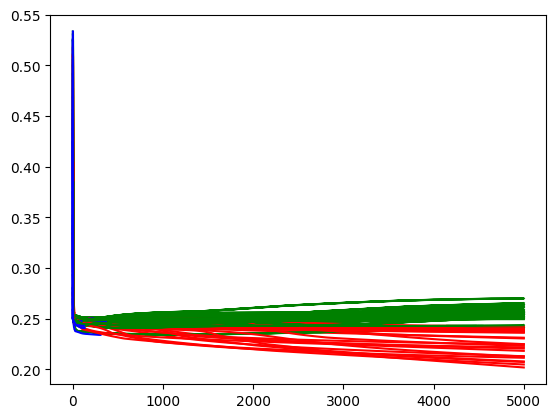

In [175]:
neurons = select_params(X_train, y_train, 1)

Rede com 15 neurônios obteve melhor desempenho considerando erro de validação.

In [177]:
neurons

15

Rede de uma camada com 15 neurônios agora utilizando todos os dados de treino.

In [60]:
f = open(f"MLP/HOG/error.txt","a+")
f.write(f"MLP - DATASET HOG\n\n")
f.write(f"Treino oficial com todo o conjunto de treinamneto e número de neurônios selecionado no k-fold igual a ({neurons}).\n\n")
f.close()

In [39]:
ns = 1

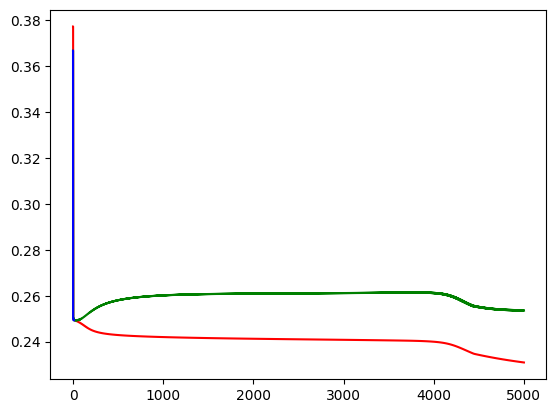

In [61]:
A, B, error = train(X_train, y_train, X_valid, y_valid, neurons, ns, 'HOG')

In [62]:
error

0.2492933740847355

Verificando erro no conjunto de teste.
Resultado próximo ao obtido com conjunto de treino, demonstrando não ter ocorrido overfit.

In [63]:
error_test = test(X_test, y_test, A, B)

In [64]:
error_test

0.250510319694058

In [65]:
f = open(f"MLP/HOG/config.txt","a+")
f.write(f"MLP - DATASET HOG")
f.write(f"\n\n")
f.write(f"Número de neurônios: {neurons}\n")
f.write(f"Erro de validação: {error}\n\n")
f.write(f"Erro de teste: {error_test}\n\n")
f.write(f"\n\n")
f.close()

Gerando matriz de confusão:

In [66]:
y_predict = neural_network_test(X_test, A, B)
y_predict = [0 if pred < 0.5 else 1 for pred in y_predict]

In [185]:
print(classification_report(y_pred=y_predict, y_true=y_test, labels=[0,1]))

              precision    recall  f1-score   support

           0       0.50      0.55      0.52       457
           1       0.55      0.51      0.53       503

    accuracy                           0.53       960
   macro avg       0.53      0.53      0.53       960
weighted avg       0.53      0.53      0.53       960



In [72]:
df = pd.DataFrame({"y_test" : y_test, "y_predict" : y_predict})
df.to_csv("MLP/HOG/compare_y.csv", index=False)

Salvando pesos.

In [67]:
with open('./weights/MLP/HOG/A.npy', 'wb') as f:
    np.save(f, A)

In [68]:
with open('./weights/MLP/HOG/B.npy', 'wb') as f:
    np.save(f, B)

Testando recupração de pesos gravados em disco.

In [69]:
with open('./weights/MLP/HOG/A.npy', 'rb') as f:
    A_load = np.load(f)

In [70]:
with open('./weights/MLP/HOG/B.npy', 'rb') as f:
    B_load = np.load(f)

In [71]:
error_test_load = test(X_test, y_test, A_load, B_load)
error_test_load

0.250510319694058

## LBP

In [73]:
df = pd.read_parquet(r'../../data/preprocessed/feature_matrix_lbp.parquet')

In [74]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,51,52,53,54,55,56,57,58,59,match
0,0.624000,0.0,0.0,0.0,0.673524,0.0,0.0,0.0,0.367238,0.0,...,0.502857,0.0,0.0,0.0,0.448762,0.0,0.0,0.0,0.417524,True
1,0.729143,0.0,0.0,0.0,0.736762,0.0,0.0,0.0,0.450286,0.0,...,0.271238,0.0,0.0,0.0,0.848762,0.0,0.0,0.0,0.412190,True
2,0.688000,0.0,0.0,0.0,0.857905,0.0,0.0,0.0,0.317714,0.0,...,0.561524,0.0,0.0,0.0,0.592000,0.0,0.0,0.0,0.550095,True
3,0.652190,0.0,0.0,0.0,0.876190,0.0,0.0,0.0,0.513524,0.0,...,0.228571,0.0,0.0,0.0,0.623238,0.0,0.0,0.0,0.579048,True
4,0.670476,0.0,0.0,0.0,0.649143,0.0,0.0,0.0,0.673524,0.0,...,0.369524,0.0,0.0,0.0,0.711619,0.0,0.0,0.0,0.518857,True


In [75]:
X = df.iloc[:, 1:-1].values
y = df.iloc[:, -1].values

In [76]:
X.shape

(3197, 59)

In [77]:
y = [int(tag is True) for tag in y]

In [78]:
y = np.array(y)

Separando dados de treino e teste.

In [79]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [80]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.20, random_state=42)

Utilizando apenas dados de treino para seleção do número de neurônios para treinamneto final.

VALID: 0.24931735950933756
VALID: 0.24859784680472255
VALID: 0.25005667774862844
VALID: 0.24771352180089218
VALID: 0.24955406450749967
PARAM: 1 ERROR: 0.24904789407421607
VALID: 0.24713190490353673
VALID: 0.24572313540335344
VALID: 0.2500586939002362
VALID: 0.24957728885054248
VALID: 0.24954696538096424
PARAM: 5 ERROR: 0.24840759768772663
VALID: 0.2493392291832937
VALID: 0.24634538524416652
VALID: 0.25005081252319317
VALID: 0.2294709893694338
VALID: 0.2495411947008684
PARAM: 10 ERROR: 0.24494952220419114
VALID: 0.2472666927141809
VALID: 0.24846379402427524
VALID: 0.2500500110065966
VALID: 0.2375787156879946
VALID: 0.2495589210208574
PARAM: 15 ERROR: 0.24658362689078092
VALID: 0.24933118414581643
VALID: 0.24414465114849296
VALID: 0.24654452361962126
VALID: 0.2316893301959907
VALID: 0.24953003664980486
PARAM: 20 ERROR: 0.24424794515194526
VALID: 0.2489069124529499
VALID: 0.24479071885651182
VALID: 0.2500779320862397
VALID: 0.24633798304599053
VALID: 0.24949107365613163
PARAM: 25 ERROR: 0

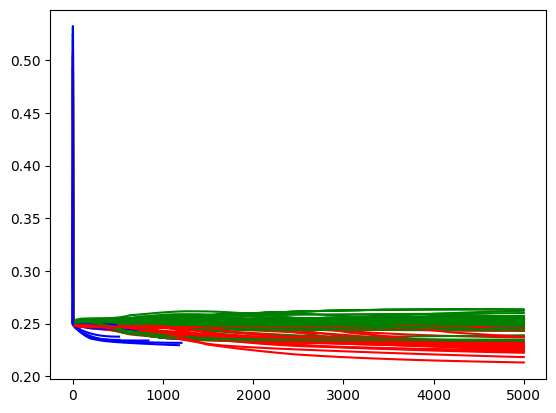

In [205]:
neurons = select_params(X_train, y_train, 1)

Rede com 15 neurônios, para o conjunto de dados LBP, obteve melhor desempenho considerando erro de validação.

In [206]:
neurons

20

Rede de uma camada com 15 neurônios agora utilizando todos os dados de treino.

In [85]:
f = open(f"MLP/LBP/error.txt","a+")
f.write(f"MLP - DATASET LBP\n\n")
f.write(f"Treino oficial com todo o conjunto de treinamneto e número de neurônios selecionado no k-fold igual a ({neurons}).\n\n")
f.close()

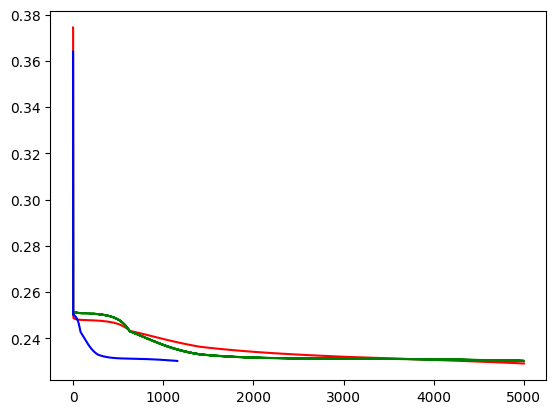

In [86]:
A, B, error = train(X_train, y_train, X_valid, y_valid, neurons, 1, 'LBP')

In [87]:
error

0.2302097102099796

Verificando erro no conjunto de teste.
Resultado próximo ao obtido com conjunto de treino, demonstrando não ter ocorrido overfit.

In [88]:
error_test = test(X_test, y_test, A, B)

In [89]:
error_test

0.2379034417684094

In [90]:
f = open(f"MLP/LBP/config.txt","a+")
f.write(f"MLP - DATASET LBP")
f.write(f"\n\n")
f.write(f"Número de neurônios: {neurons}\n")
f.write(f"Erro de validação: {error}\n\n")
f.write(f"Erro de teste: {error_test}\n\n")
f.write(f"\n\n")
f.close()

Gerando matriz de confusão:

In [91]:
y_predict = neural_network_test(X_test, A, B)
y_predict = [0 if pred < 0.5 else 1 for pred in y_predict]

In [92]:
print(classification_report(y_pred=y_predict, y_true=y_test, labels=[0,1]))

              precision    recall  f1-score   support

           0       0.58      0.53      0.55       457
           1       0.60      0.65      0.63       503

    accuracy                           0.59       960
   macro avg       0.59      0.59      0.59       960
weighted avg       0.59      0.59      0.59       960



In [98]:
df = pd.DataFrame({"y_test" : y_test, "y_predict" : y_predict})
df.to_csv("MLP/LBP/compare_y.csv", index=False)

Salvando pesos.

In [93]:
with open('./weights/MLP/LBP/A.npy', 'wb') as f:
    np.save(f, A)

In [94]:
with open('./weights/MLP/LBP/B.npy', 'wb') as f:
    np.save(f, B)

Testando recupração de pesos gravados em disco.

In [95]:
with open('./weights/MLP/LBP/A.npy', 'rb') as f:
    A_load = np.load(f)

In [96]:
with open('./weights/MLP/LBP/B.npy', 'rb') as f:
    B_load = np.load(f)

In [97]:
error_test_load = test(X_test, y_test, A_load, B_load)
error_test_load

0.2379034417684094